In [1]:
pathsTreino = {
    "camera1": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera1.txt"],
    "camera3": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera3.txt"],
    "camera5": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera5.txt"],
    "camera7": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera7.txt"],
    "camera9": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera9.txt"],
    "UFPR04": ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/UFPR04.txt"],
    "UFPR05": ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/UFPR05.txt"],
    "A": ["CNRPark-Patches-150x150/", "splits/CNRParkAB/A.txt"]
}
pathsTeste = {
    "camera2": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera2.txt"],
    "camera4": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera4.txt"],
    "camera6": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera6.txt"],
    "camera8": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera8.txt"],
    "PUC": ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/PUC.txt"],
    "B": ["CNRPark-Patches-150x150/", "splits/CNRParkAB/B.txt"]
}

In [2]:
import os   
import cv2
import torch
import random
import argparse
import xmltodict
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

class Data:
    def __init__(self, img_path, target_path, transforms = None, sample = 1):
        with open(target_path, 'r') as f:
            lines = f.readlines()
            rand_list = random.sample(range(0, len(lines)), int(sample * len(lines)))
            self.img_list = [os.path.join(img_path, i.split()[0]) for i in lines]
            self.img_list = [self.img_list[a] for a in rand_list]
            self.label_list = [i.split()[1] for i in lines]
            self.label_list = [self.label_list[a] for a in rand_list]

            self.transforms = transforms
    
    def __getitem__(self, index):
        try:
            img_path = self.img_list[index]
            img = Image.open(img_path)
            img = self.transforms(img)
            label = self.label_list[index]
        except:
            return None
        return img, label
    
    def __len__(self):
        return len(self.label_list)
    
    def __add__(self, other):
        self.img_list = self.img_list + other.img_list
        rand_list = random.sample(range(0, len(self.img_list)), len(self.img_list))
        self.label_list = self.label_list + other.label_list
        self.img_list = [self.img_list[a] for a in rand_list]
        self.label_list = [self.label_list[a] for a in rand_list]


In [3]:
def imshow(train_loader):
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)) * 0.5 + 0.5)
    plt.show()

In [4]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=2, init_weights=False):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 48, 11, 4, 2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2), 
        nn.Conv2d(48, 128, kernel_size=5, padding=2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),        
        nn.Conv2d(128, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(128 * 6 * 6, 2048),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(2048, 2048),
      nn.ReLU(inplace=True),
      nn.Linear(2048, num_classes),
    )
    if init_weights:
      self._initialize_weights()
  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      return self.classifier(x)

  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0) 


class mAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.input_channel = 3
        self.num_output = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channel, out_channels= 16, kernel_size= 11, stride= 4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size = 5),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 16, out_channels= 20, kernel_size= 5, stride= 1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size = 5),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 30, kernel_size= 3, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(30*3*3, out_features=48),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=48, out_features=2)
        )

    def forward(self, x):
        x = self.layer3(self.layer2(self.layer1(x)))
        x = x.view(x.size(0), -1)
        x = self.layer5(self.layer4(x))
        m = nn.Softmax(dim=1)
        return m(x)

In [5]:
def train(epoch, train_dataset, net, criterion, device):
    train_loader = DataLoader(train_dataset, batch_size=64, \
            shuffle=True, num_workers=0,drop_last=False, collate_fn=collate_fn)
    epochLoss = []
    print("Number of batches to train: ", str(len(train_loader)))
    for ep in range(epoch):  
        if ep >= 12:
            learning_rate = 0.0025
        elif ep >= 6:
            learning_rate = 0.005
        else:
            learning_rate = 0.01
        running_loss = 0.0
        print("Epoch {}.".format(ep+1))
        for i, data in enumerate(train_loader,1):
            inputs, labels = data
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print("Epoch {}.\tBatch {}.\tLoss = {:.3f}.".format(ep+1, i+1, running_loss))
            if i % len(train_loader) == len(train_loader) - 1:    
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / len(train_loader)))
                epochLoss.append(running_loss / len(train_loader))
                running_loss = 0.0

    print('Finished Training.')
    return epochLoss


In [6]:
def test(test_dataset, net, device):
    print("\nTesting starts now...")
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, \
                            num_workers=0, collate_fn=collate_fn)
    correct = 0
    total = 0
    item = 1
    y_true = []
    y_pred = []
    print("Number of batches to test: ", str(len(test_loader)))
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            if i % 10 == 0:
                print("Testing on batch {}".format(item))
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            images = images.to(device)
            labels = labels.to(device)
            y_pred.append(labels)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            item += 1
    return (correct/total), roc_auc_score(torch.cat(y_pred), torch.cat(y_true))


In [7]:
device = torch.device("cpu")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),  # normalize to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

In [8]:
for i, key in enumerate(pathsTreino, 1):
    if i == 1:
        trainDataset = Data(pathsTreino[key][0], pathsTreino[key][1], transform, sample = 0.1)
    else:
        trainDataset + Data(pathsTreino[key][0], pathsTreino[key][1], transform, sample = 0.1)

In [9]:
testDatasets = []
for key in pathsTeste:
    testDatasets.append(Data(pathsTeste[key][0], pathsTeste[key][1], transform, sample = 0.1))

### Treinamento do modelo

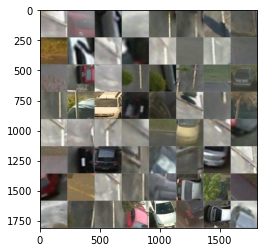

In [10]:
train_loader = DataLoader(trainDataset, batch_size=64, shuffle=True, drop_last=False)
imshow(train_loader)

In [14]:
net = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [15]:
RETRAIN = False

In [16]:
if RETRAIN:
    loss = train(18, trainDataset, net, criterion, device)
    PATH = 'models/AlexNettrainDistribution.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(loss)
    with open("losses/trainLossAlexNetTrainDistribution.txt", "w") as file:
        file.write(str(loss))   
else:
    PATH = 'models/AlexNettrainDistribution.pth'
    net.load_state_dict(torch.load(PATH))

In [17]:
results = pd.DataFrame()

In [16]:
for i, key in enumerate(pathsTeste):
    accuracy, auc = test(testDatasets[i], net, device)
    print("\nThe accuracy of testing on '{}' is {:.3f}.".format(key, accuracy))
    results = pd.concat([results, pd.DataFrame({
                                            "Dataset": [key],
                                            "Accuracy": [accuracy],
                                            "Auc": [auc],
                                            "Sample": [0.1]})])


Testing starts now...
Number of batches to test:  7
Testing on batch 1

The accuracy of testing on 'camera2' is 0.941.

Testing starts now...
Number of batches to test:  26
Testing on batch 1
Testing on batch 11


In [17]:
results

,Dataset,Accuracy,Auc,Sample
0,camera2,0.929095,0.934185,0.1
0,camera4,0.940253,0.943253,0.1
0,camera6,0.944251,0.943994,0.1
0,camera8,0.948899,0.949136,0.1
0,PUC,0.949908,0.951729,0.1
0,B,0.853354,0.863530,0.1


In [18]:
results.to_csv("results/AlexNettrainDistributionResults.csv")

### Custom Image Inference

In [18]:
def inference(net, annotations, path):
    preds = []
    positions = []
    total = 0
    item = 1
    correct = 0
    for im in annotations:
        print('Inference for image: ' + str(im))
        fullImage = Image.open(path + im)
        for space in annotations[im]["regions"]:
            x = annotations[im]["regions"][str(space)]['shape_attributes']['all_points_x']
            y = annotations[im]["regions"][str(space)]['shape_attributes']['all_points_y']
            xy = list(zip(annotations[im]["regions"][str(space)]['shape_attributes']['all_points_x'], annotations[im]["regions"][str(space)]['shape_attributes']['all_points_y']))
            positions.append(xy)
            img = fullImage.crop((min(x), min(y), max(x), max(y)))
            img = transform(img).to(device)[None, :]
            outputs = net(img)
            _, predicted = torch.max(outputs.data, 1)
            preds.append(int(predicted))

            if annotations[im]["regions"][str(space)]["region_attributes"]["label"] == "Livre":
                label = torch.Tensor([0]).to(device)
            else:
                label = torch.Tensor([1]).to(device)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            item += 1

    return positions, preds, correct, total

In [19]:
def inferenceShow(path, positions, preds):
  print(path)
  img = cv2.imread(path)
  for i, co in enumerate(positions):
    pts = np.array(co, np.int32)
    pts = pts.reshape((-1,1,2))
    if preds[i] == 0:
      c = (0,255,255)
    else:
      c = (255, 0, 0)
    cv2.polylines(img,[pts],True,c, 2)

  img = cv2.resize(img, (1280, 720))
  while(1):
      cv2.imshow('image', img)
      if cv2.waitKey(1):
          break
  #cv2.destroyAllWindows()

### Custom Video Inference

In [21]:
for r, c, fi in os.walk('CIn/frames/'):
    fi = list(filter(lambda x: x.endswith('json'), fi))
    fi.sort(key=lambda x: int(x[:-5]))
    for f in fi:
        if f.endswith('.json'):
            annotations = pd.read_json(r + f)
            positions, preds, correct, total = inference(net, annotations, r)
            inferenceShow(r + f[:-4] + 'jpg', positions, preds)

Inference for image: 0.jpg
CIn/frames/0.jpg
Inference for image: 1.jpg
CIn/frames/1.jpg
Inference for image: 2.jpg
CIn/frames/2.jpg
Inference for image: 3.jpg
CIn/frames/3.jpg
Inference for image: 4.jpg
CIn/frames/4.jpg
Inference for image: 5.jpg
CIn/frames/5.jpg
Inference for image: 6.jpg
CIn/frames/6.jpg
Inference for image: 7.jpg
CIn/frames/7.jpg
Inference for image: 8.jpg
CIn/frames/8.jpg
Inference for image: 9.jpg
CIn/frames/9.jpg
Inference for image: 10.jpg
CIn/frames/10.jpg
Inference for image: 11.jpg
CIn/frames/11.jpg
Inference for image: 12.jpg
CIn/frames/12.jpg
Inference for image: 13.jpg
CIn/frames/13.jpg
Inference for image: 14.jpg
CIn/frames/14.jpg
Inference for image: 15.jpg
CIn/frames/15.jpg
Inference for image: 16.jpg
CIn/frames/16.jpg
Inference for image: 17.jpg
CIn/frames/17.jpg
Inference for image: 18.jpg
CIn/frames/18.jpg
Inference for image: 19.jpg
CIn/frames/19.jpg
Inference for image: 20.jpg
CIn/frames/20.jpg
Inference for image: 21.jpg
CIn/frames/21.jpg
Inferenc

KeyboardInterrupt: 

: 